# Imports

In [1]:
import pickle

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

from khan_helpers import Experiment
from khan_helpers.constants import DATA_DIR, FIG_DIR
from khan_helpers.functions import _ts_to_sec, preprocess_text, set_figure_style

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define some helper functions

In [2]:
def jaccard_str(charray_a, charray_b):
    a = set(charray_a.item())
    b = set(charray_b.item())
    return len(a & b) / len(a | b)

In [3]:
def similarity_matrix_text(textlist_a, textlist_b):
    charray_a = np.char.split(textlist_a)[:, None]
    charray_b = np.char.split(textlist_b)[:, None]
    return cdist(charray_a, charray_b, metric=jaccard_str)

# Load data, get topic vectors and raw text for lectures & quiz questions

In [4]:
exp = Experiment()

# lecture trajectories
forces_traj = exp.forces_traj
bos_traj = exp.bos_traj

# quiz question topic vectors
forces_qs = exp.get_question_vecs(lectures='forces')
bos_qs = exp.get_question_vecs(lectures='bos')
general_qs = exp.get_question_vecs(lectures='general')

# lecture sliding window text (preprocessed)
forces_windows = exp.forces_windows
bos_windows = exp.bos_windows

# quiz question text (repeat initial preprocessing)
questions_text_raw = exp.questions['question'].to_numpy()
questions_text = np.array(preprocess_text(questions_text_raw))
forces_qs_text = questions_text[exp.questions.query('lecture == 1').index - 1]
bos_qs_text = questions_text[exp.questions.query('lecture == 2').index - 1]
general_qs_text = questions_text[exp.questions.query('lecture == 0').index - 1]

# most similar periods of lecture content to each question
peak_intervals = pickle.loads(DATA_DIR.joinpath('qcorrs_peak_intervals.p').read_bytes())

# Compute correlation between topic vectors and Jaccard similarity between raw words

In [5]:
forces_qcorrs = 1 - cdist(forces_traj, forces_qs, 'correlation')
bos_qcorrs = 1 - cdist(bos_traj, bos_qs, 'correlation')

forces_qsim_text = similarity_matrix_text(forces_windows, forces_qs_text)
bos_qsim_text = similarity_matrix_text(bos_windows, bos_qs_text)

# Show similarities timeseries for both measures, highlight some example questions

In [6]:
# show one example question from each lecture
QS_TO_SHOW = [7, 17]

# styling of foreground and background questions' timeseries
fg_alpha = 1
bg_alpha = 0.22
bg_legend_apha = 0.5
fg_linewidth = 3
bg_linewidth = 1
bg_legend_linewidth = 1.5

In [7]:
# get lecture timepoint most similar to sample questions
forces_example_tpt = forces_qcorrs[:, QS_TO_SHOW[0]-1].argmax()
bos_example_tpt = bos_qcorrs[:, QS_TO_SHOW[1]-16].argmax()

# get pre-computed surrounding interval of highly similar timepoints
forces_example_timespan = next(
    (i, j) for (i, j) in peak_intervals['forces'][QS_TO_SHOW[0]-1][1] if i < forces_example_tpt < j
)
bos_example_timespan = next(
    (i, j) for (i, j) in peak_intervals['bos'][QS_TO_SHOW[1]-16][1] if i < bos_example_tpt < j
)

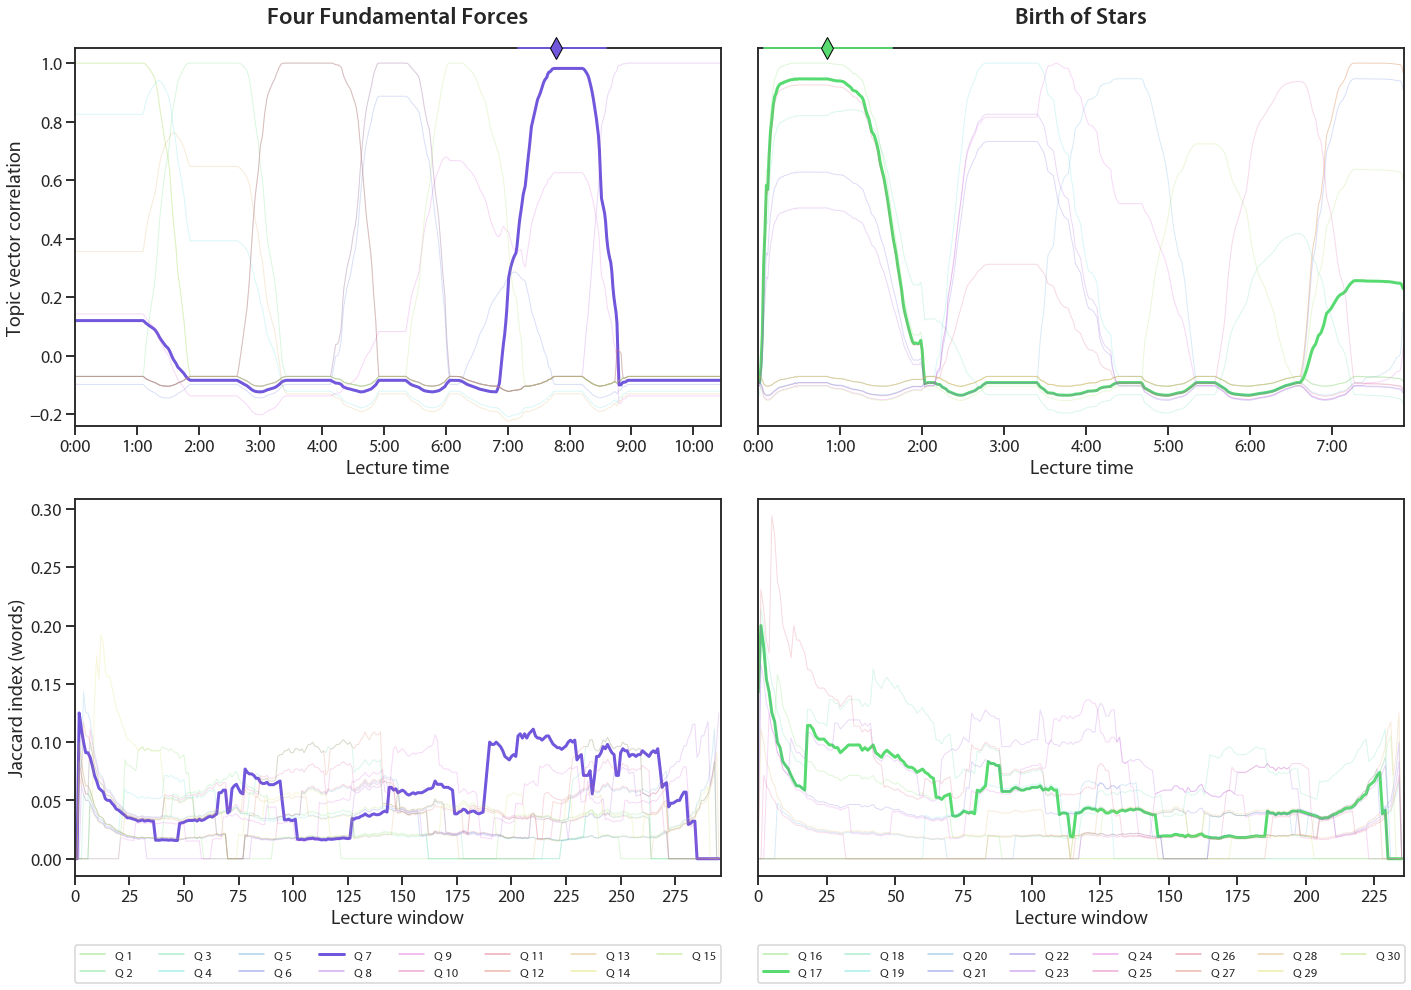

In [8]:
palette = sns.hls_palette(15, h=.3)

with (
    sns.plotting_context('talk', font_scale=1.1), 
    sns.axes_style('ticks'), 
    sns.color_palette(palette)
):
    set_figure_style()
    fig, axarr = plt.subplots(2, 2, sharey='row')
    ((fvax, bvax), 
     (ftax, btax)) = axarr
    fig.set_size_inches(20, 14)
    
    # ==================== Four Fundamental Forces =====================
    # topic vector similarity:
    for ix, qcorr in enumerate(forces_qcorrs.T, start=1):
        if ix in QS_TO_SHOW:
            alpha = fg_alpha
            linewidth = fg_linewidth
        else:
            alpha = bg_alpha
            linewidth = bg_linewidth
        
        fvax.plot(qcorr, alpha=alpha, linewidth=linewidth)
        
    # get current question's color without causing the color 
    # cycler to progress to the next color 
    tpt_color = f'C{QS_TO_SHOW[0]-1}'
    fvax.plot(forces_example_tpt, 
              1.05, 
              color=tpt_color, 
              linestyle='', 
              marker='d', 
              markersize=15, 
              markeredgecolor='k',
              clip_on=False, 
              zorder=11)
    tpts_in_interval = np.arange(*forces_example_timespan)
    fvax.plot(tpts_in_interval, 
              [1.05]*len(tpts_in_interval), 
              tpt_color, 
              linewidth=fvax.spines['top'].get_linewidth(),
              clip_on=False,
              zorder=10)

    fvax.set_xlim(0, len(forces_traj))
    fvax.set_ylim(-.24, 1.05)
    fvax.set_xlabel('Lecture time')
    fvax.set_ylabel('Topic vector correlation')
    fvax.set_title('Four Fundamental Forces', 
                   y=1.05, 
                   fontsize='large', 
                   fontweight='semibold')
    fvax.set_xticks(range(0, len(forces_traj), 60), 
                    [f'{i//60}:00' for i in range(0, len(forces_traj), 60)])
    fvax.grid(False)

    # word overlap similarity:
    for ix, qsim in enumerate(forces_qsim_text.T, start=1):
        if ix in QS_TO_SHOW:
            alpha = fg_alpha
            linewidth = fg_linewidth
        else:
            alpha = bg_alpha
            linewidth = bg_linewidth
        
        ftax.plot(qsim, alpha=alpha, linewidth=linewidth)

    ftax.set_xlim(0, len(forces_windows))
    ftax.set_xticks(range(0, len(forces_windows)+1, 25))
#     ftax.set_ylim(-.24, 1.05)
    ftax.set_xlabel('Lecture window')
    ftax.set_ylabel('Jaccard index (words)')
    leg = ftax.legend(labels=[f'Q {i}' for i in range(1, 16)], 
                      fontsize=12.5, 
                      loc=3, 
                      ncol=8, 
                      mode='expand',
                      bbox_to_anchor=(-0.01, -.3, 1.02, 1))
    for ix, handle in enumerate(leg.legendHandles, start=1):
        if ix not in QS_TO_SHOW:
            handle.set_alpha(bg_legend_apha)
            handle.set_linewidth(bg_legend_linewidth)
    
    # ========================= Birth of Stars =========================
    # topic vector similarity:
    for ix, qcorr in enumerate(bos_qcorrs.T, start=16):
        if ix in QS_TO_SHOW:
            alpha = fg_alpha
            linewidth = fg_linewidth
        else:
            alpha = bg_alpha
            linewidth = bg_linewidth
        
        bvax.plot(qcorr, alpha=alpha, linewidth=linewidth)
        
    # get current question's color without causing the color 
    # cycler to progress to the next color 
    tpt_color = f'C{QS_TO_SHOW[1]-1}'
    bvax.plot(bos_example_tpt, 
              1.05, 
              color=tpt_color, 
              linestyle='', 
              marker='d', 
              markersize=15, 
              markeredgecolor='k',
              clip_on=False, 
              zorder=11)
    tpts_in_interval = np.arange(*bos_example_timespan)
    bvax.plot(tpts_in_interval, 
              [1.05]*len(tpts_in_interval), 
              tpt_color, 
              linewidth=bvax.spines['top'].get_linewidth(),
              clip_on=False,
              zorder=10)
    
    bvax.set_xlim(0, len(bos_traj))
#     bvax.set_ylim(-.24, 1.05)
    bvax.set_xlabel('Lecture time')
    bvax.set_title('Birth of Stars', 
                   y=1.05, 
                   fontsize='large', 
                   fontweight='semibold')
    bvax.tick_params(axis='y', length=0)
    bvax.set_xticks(range(0, len(bos_traj), 60),
                    [f'{i//60}:00' for i in range(0, len(bos_traj), 60)])
#     fvax.grid(False)

    # word overlap similarity:
    for ix, qsim in enumerate(bos_qsim_text.T, start=16):
        if ix in QS_TO_SHOW:
            alpha = fg_alpha
            linewidth = fg_linewidth
        else:
            alpha = bg_alpha
            linewidth = bg_linewidth
        
        btax.plot(qsim, alpha=alpha, linewidth=linewidth)

    btax.set_xlim(0, len(bos_windows))
    btax.set_xticks(range(0, len(bos_windows)+1, 25))
#     btax.set_ylim(-.24, 1.05)
    btax.set_xlabel('Lecture window')
    btax.tick_params(axis='y', length=0)
    leg = btax.legend(labels=[f'Q {i}' for i in range(16, 31)], 
                      fontsize=12.5, 
                      loc=3, 
                      ncol=8, 
                      mode='expand',
                      bbox_to_anchor=(-0.01, -.3, 1.02, 1))
    for ix, handle in enumerate(leg.legendHandles, start=16):
        if ix not in QS_TO_SHOW:
            handle.set_alpha(bg_legend_apha)
            handle.set_linewidth(bg_legend_linewidth)
    
    plt.tight_layout()
#     plt.savefig(FIG_DIR.joinpath('similarity-timeseries-correlation-jaccard.pdf'), 
#                 bbox_inches='tight')
    plt.show()
    

# Get lecture content at example questions' most similar timepoints

In [9]:
forces_question = exp.questions.loc[QS_TO_SHOW[0], 'question']
forces_transcript_lines = exp.forces_transcript.splitlines()
forces_transcript_text = np.array(forces_transcript_lines[1::2])
forces_timestamps = np.array(forces_transcript_lines[::2])
forces_timestamps_float = np.fromiter(map(_ts_to_sec, forces_timestamps), dtype=float)
text_ixs = np.where((forces_timestamps_float >= forces_example_timespan[0]) & 
                    (forces_timestamps_float <= forces_example_timespan[1]))[0]
forces_lecture_text = ' '.join(forces_transcript_text[text_ixs])

bos_question = exp.questions.loc[QS_TO_SHOW[1], 'question']
bos_transcript_lines = exp.bos_transcript.splitlines()
bos_transcript_text = np.array(bos_transcript_lines[1::2])
bos_timestamps = np.array(bos_transcript_lines[::2])
bos_timestamps_float = np.fromiter(map(_ts_to_sec, bos_timestamps), dtype=float)
text_ixs = np.where((bos_timestamps_float >= bos_example_timespan[0]) & 
                    (bos_timestamps_float <= bos_example_timespan[1]))[0]
bos_lecture_text = ' '.join(bos_transcript_text[text_ixs])

In [10]:
print(forces_question, '\n\n', forces_lecture_text)

Which of the following are the primary two fundamental forces acting in opposition between the positively-charged protons in an atom's nucleus? 

 reference now the strongest of the force is probably the best name of them all and that's the strong force that is the strong force the strong force and although you probably haven't seen this yet in our in chemistry classes it actually applies very strongly in chemistry because from the get-go when you first learn when you first learn about atoms let me draw a helium atom a helium atom has two protons and it's nucleus two protons in its nucleus and it has two neutrons and then it also has two electrons circulating around so it has an electron and I can draw the electrons is much smaller than well I won't I won't try to do anything in relative size but it has two electrons floating around and one question that may or may not have jumped into your mind when you first saw this model of an atom is like well I see why the electrons are attracted

In [11]:
print(bos_question, '\n\n', bos_lecture_text)

Which of the following occurs as a cloud of atoms gets more dense? 

 and I say huge cloud huge both in distance and in mass if you were to combine all of the hydrogen atoms it would just be this really really massive thing so you have this huge cloud well we know that gravity would make the atoms actually attracted to each other instantly we normally don't think about the gravity of atoms but it would slowly affect these atoms and they'd slowly draw close to each other it would slowly condense they'd slowly they slowly move towards the center of mass of all of the atoms they'd slowly move in and so if we fast forward if we fast forward this cloud is going to get denser and denser it's going to get denser and denser and the hydrogen atoms are going to start bumping into each other and rubbing up against each other and interacting with each other and so it's going to get denser and denser and denser and remember was a huge mass of hydrogen atoms so the temperature is going up the temper

# Show distributions of similarities to lecture timepoints for each question, for both similarity measires

In [12]:
similarity_df = pd.concat((
    pd.DataFrame(forces_qcorrs).melt(),
    pd.DataFrame(bos_qcorrs).melt(),
    pd.DataFrame(forces_qsim_text).melt(), 
    pd.DataFrame(bos_qsim_text).melt()
)).reset_index(drop=True)
similarity_df.columns = ['Question', 'Similarity (raw)']
similarity_df['Similarity metric'] = (
    ['Topic vector correlation'] * (forces_qcorrs.size + bos_qcorrs.size) + 
    ['Jaccard index (words)'] * (forces_qsim_text.size + bos_qsim_text.size)
)
similarity_df['lecture'] = (
    ['Four Fundamental Forces'] * forces_qcorrs.size + 
    ['Birth of Stars'] * bos_qcorrs.size + 
    ['Four Fundamental Forces'] * forces_qsim_text.size + 
    ['Birth of Stars'] * bos_qsim_text.size
)
similarity_df.loc[similarity_df['lecture'] == 'Four Fundamental Forces', 'Question'] += 1
similarity_df.loc[similarity_df['lecture'] == 'Birth of Stars', 'Question'] += 16

# min-max normalize similarity scores within each question to put 
# the two distributions on a common scale 
similarity_df['Similarity (normalized)'] = (
    similarity_df
    .groupby(['Similarity metric', 'Question'])['Similarity (raw)']
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)

similarity_df

,Question,Similarity (raw),Similarity metric,lecture,Similarity (normalized)
0,1,1.000000,Topic vector correlation,Four Fundamental Forces,1.00000
1,1,1.000000,Topic vector correlation,Four Fundamental Forces,1.00000
2,1,1.000000,Topic vector correlation,Four Fundamental Forces,1.00000
3,1,1.000000,Topic vector correlation,Four Fundamental Forces,1.00000
4,1,1.000000,Topic vector correlation,Four Fundamental Forces,1.00000
...,...,...,...,...,...
24475,30,0.105263,Jaccard index (words),Birth of Stars,1.00000
24476,30,0.062500,Jaccard index (words),Birth of Stars,0.59375
24477,30,0.000000,Jaccard index (words),Birth of Stars,0.00000
24478,30,0.000000,Jaccard index (words),Birth of Stars,0.00000


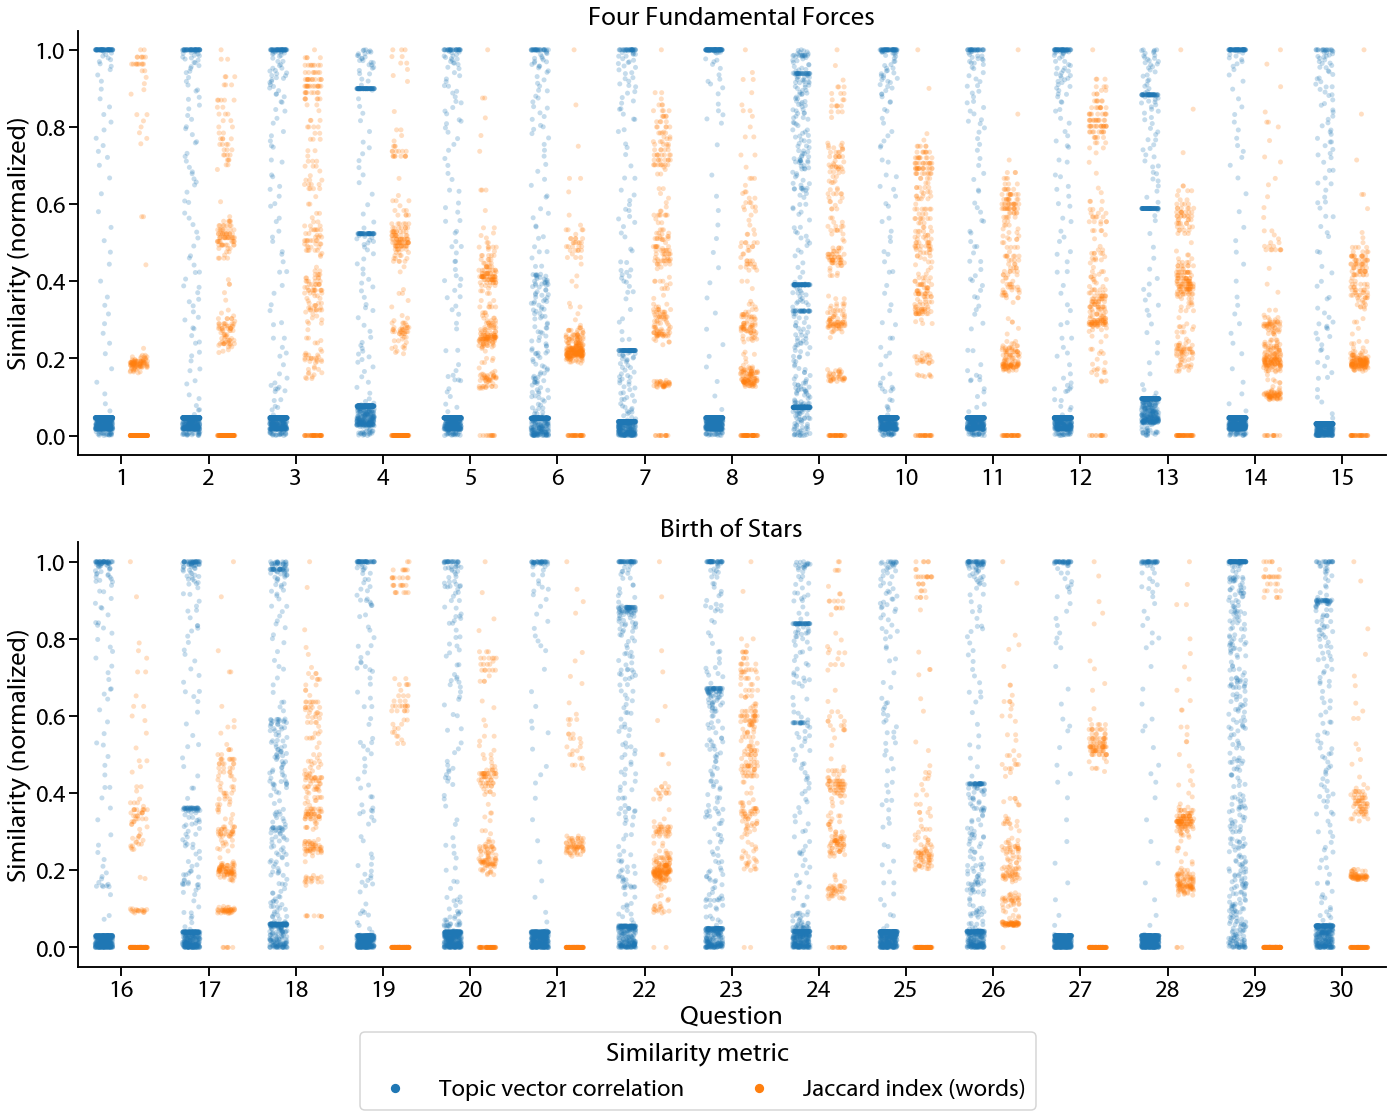

In [13]:
with sns.plotting_context('talk', font_scale=1.5):
    g = sns.catplot(data=similarity_df, 
                    kind='strip',
                    x='Question',
                    y='Similarity (normalized)',
                    hue='Similarity metric',
                    row='lecture',
                    dodge=True,
                    jitter=0.2,
                    alpha=0.25,
                    s=5,
                    sharex=False)
    g.set_titles('{row_name}')
    g.fig.set_size_inches(20, 15)
    sns.move_legend(g, 'lower center', bbox_to_anchor=(0.5, -0.06), ncol=2, frameon=True)
    fax, bax = g.axes
    plt.tight_layout()
#     plt.savefig(FIG_DIR.joinpath('lecture-similarity-distributions-by-question.pdf'), 
#                 bbox_inches='tight')
    plt.show()